In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,confusion_matrix
from scipy import stats
from scipy.stats import norm

In [2]:
SEED = 14
np.random.seed(SEED)

plt.style.use('seaborn-white')

# Read Data

In [3]:
data = pd.read_csv('housing-boston.csv',header=None)
data.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
207,0.25199,0.0,10.59,0,0.489,5.783,72.7,4.3549,4,277,18.6,389.43,18.06,22.5
341,0.01301,35.0,1.52,0,0.442,7.241,49.3,7.0379,1,284,15.5,394.74,5.49,32.7
65,0.03584,80.0,3.37,0,0.398,6.290,17.8,6.6115,4,337,16.1,396.90,4.67,23.5
27,0.95577,0.0,8.14,0,0.538,6.047,88.8,4.4534,4,307,21.0,306.38,17.28,14.8
348,0.01501,80.0,2.01,0,0.435,6.635,29.7,8.3440,4,280,17.0,390.94,5.99,24.5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 14 columns):
0     452 non-null float64
1     452 non-null float64
2     452 non-null float64
3     452 non-null int64
4     452 non-null float64
5     452 non-null float64
6     452 non-null float64
7     452 non-null float64
8     452 non-null int64
9     452 non-null int64
10    452 non-null float64
11    452 non-null float64
12    452 non-null float64
13    452 non-null float64
dtypes: float64(11), int64(3)
memory usage: 49.6 KB


Data has 452 rows and 14 columns. `info()` shows us that there are no null values but we have to check for the same and all but `3,8,9` are float. It looks like that columns `3,8,9` are categorical in nature

In [5]:
data.describe() # describe the data in terms of min,mx,quantiles, mean and std

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,1.420825,12.721239,10.304889,0.077434,0.540816,6.343538,65.557965,4.043570,7.823009,377.442478,18.247124,369.826504,11.441881,23.750442
std,2.495894,24.326032,6.797103,0.267574,0.113816,0.666808,28.127025,2.090492,7.543494,151.327573,2.200064,68.554439,6.156437,8.808602
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,6.300000
25%,0.069875,0.000000,4.930000,0.000000,0.447000,5.926750,40.950000,2.354750,4.000000,276.750000,16.800000,377.717500,6.587500,18.500000
50%,0.191030,0.000000,8.140000,0.000000,0.519000,6.229000,71.800000,3.550400,5.000000,307.000000,18.600000,392.080000,10.250000,21.950000
75%,1.211460,20.000000,18.100000,0.000000,0.605000,6.635000,91.625000,5.401100,7.000000,411.000000,20.200000,396.157500,15.105000,26.600000
max,9.966540,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.410000,50.000000


In [6]:
data.isna().sum().sum() # it gives the count of total null values present in the data

0

In [7]:
data.nunique()

0     451
1      26
2      76
3       2
4      80
5     405
6     347
7     360
8       9
9      66
10     46
11    320
12    409
13    210
dtype: int64

There are only 2 values in the column `3`. It is definately a categorical column

In column `8`, there are 9 unique values. 455 entries belonging to 9 classes puts this one into categorical category too

We are unsure about how to treat the values for `9`. 66 classes for 450 rows looks like a lot of classes. We will try to find that out later

There is no labels given for columns but looking at the data online we have found the below information about labels: 

1. CRIM- per capita crime rate by town
2. ZN- proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per `$10,000`
11. PTRATIO - pupil-teacher ratio by town
12. B - `1000(Bk - 0.63)^2`  where Bk is the proportion of blacks by town
13. LSTAT - `%` lower status of the population
14. MEDV - Median value of owner-occupied homes in `$1000's`

In [8]:
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 
        'LSTAT', 'MEDV']

data.columns = cols

### Helpers

In [9]:
 def regression_prob_plot(df,col_name,cols=4,force=False,PAD=3,width=15,tight=False):
        '''
        Find the relation between numerical column and all the other columns
        args:
            df: pandas dataframe
            col_name: any categorical column whose relation/distribution we want to see with all the columns in that df
            rows: number of rows for subplots
            force: whether to show each and every column
            PAD: Padding for subplots spacing
            width: used for width of graph
        '''

        rows=df.shape[1]//cols+1
        f,ax = plt.subplots(nrows=rows,ncols=cols, figsize=(width,df.shape[1]+PAD))
        ax = ax.ravel()

        for i , column in enumerate(df.columns): # if purely categorical
            ax[i].set_xlabel(column)
            sns.regplot(x=col_name, y=column, data=df,ax=ax[i], y_jitter=0.05)

        for axis_num in range(i+1,(cols*rows)): # delete the remaining empty plots
            f.delaxes(ax[axis_num])
        if tight:
            plt.tight_layout()
        plt.show()


In [10]:
def dist_skew_box_vio(df,column):
    f,ax = plt.subplots(2,2,figsize=(11,7))
    ax = ax.ravel()
    sns.distplot(df[column], fit=norm,ax=ax[0])
    stats.probplot(df[column], plot=ax[1])
    sns.boxplot(y=df[column],ax=ax[2],color='m')
    ax[2].set_xlabel(column+ ' Box')
    sns.violinplot(y=df[column],ax=ax[3],color='teal')
    ax[3].set_xlabel(column+ ' Violin')

In [11]:
def transform_data(data,t_type=0,m='min'):
    '''
    A t_type to transform data in Gaussian which is not Gaussian in nature using different techniques
    param:
        data: input data in the form of numpy array or pandas series
        t_type: transformation type 
                options:   int {
                                0: Square Root
                                1: Normalization
                                2: Sigmoid
                                3: Cube Root
                                4: Normalized Cube Root
                                5: Log
                                6: Log Max Root
                                7: Normalized Log
                                8: Normalized Log Max Root
                                9: Hyperbolic Tangent
                                10:
                            }
    out:
        transformed data 
    '''

    def normalize_(data):
        upper = data.max()
        lower = data.min()
        return (data - lower)/(upper-lower)
    
    def sigmoid_(data):
        e = np.exp(1)
        return 1/(1+e**(-data))

    def log_(data):
        if data.min()>0:
            return np.log(data)
        else:
            return np.log(data+1)
    
    
    if t_type==0:
        return np.sqrt(data)

    if t_type==1:
        return normalize_(data) # normalize
    
    elif t_type==2:
        return sigmoid_(data) # sigmoid
    
    elif t_type==3:
        return data**(1/3) # cube root

    elif t_type==4:
        return normalize_(data**(1/3)) # normalized cube root

    elif t_type==5:
        return log_(data) # log

    elif t_type==6:
        return data**(np.log(data.max())) # log-max-root 

    elif t_type==7:
        return normalize_(log_(data)) # normalized log

    elif t_type==8:
        return normalize_(data**(np.log(data.max()))) # normalized log-max-root

    elif t_type==9:
        return np.tanh(data) # hyperbolic tangent
    
    elif t_type==10:
        return data.rank(method=m).apply(lambda x: (x-1)/len(data)-1)

    else:
        print('No Suitable t_type Specified. Returning Data')
        return(data) 


# EDA

### 0

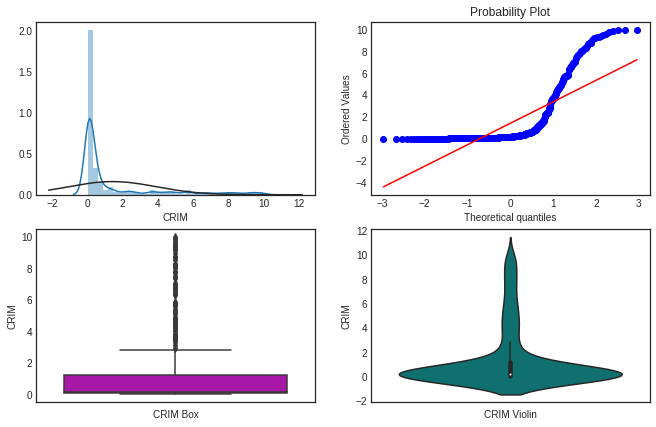

In [12]:
dist_skew_box_vio(data,'CRIM')

'CRIM' is not normally distributed as can be seen by the distribution and skew plots. There are a lot of values on the lower end of the Box and Violin plot. There are a lots of values over the quantile.

No Suitable t_type Specified. Returning Data


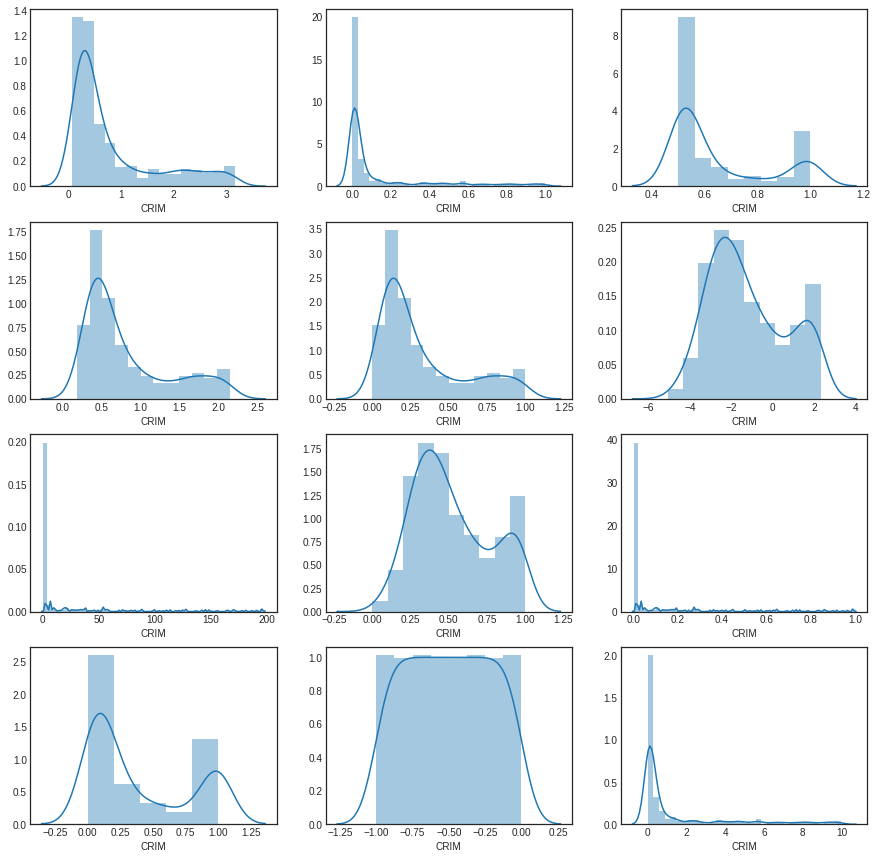

In [13]:
f,ax = plt.subplots(4,3,figsize=(15,15))
ax = ax.ravel()
for i in range(12):
    sns.distplot(transform_data(data['CRIM'],t_type=i),ax=ax[i])

Log transformation looks like a suitable transformation for the column. We will be using it.

In [14]:
data['CRIM'] = np.log(data['CRIM'])

regression_prob_plot(df.drop(['CHAS','RAD'],axis=1),'CRIM',cols=3,PAD=7)

It looks like CRIM is related to LSTAT,AGE,NOX positively and with MEDV,DIS negatively. If NOX and CRIM are very highly related, we'll have to remove one of those

### 1 

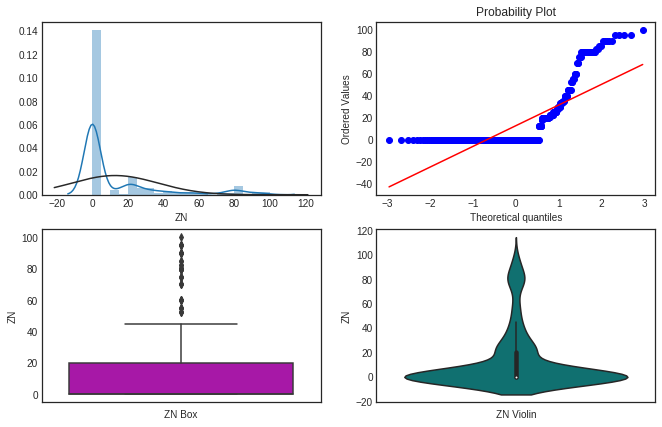

In [15]:
name = cols[1]
dist_skew_box_vio(data,name)

### 2

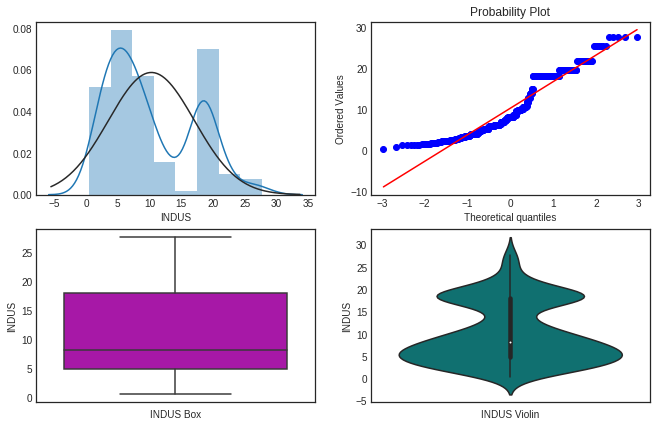

In [16]:
name = cols[2]
dist_skew_box_vio(data,name)

### 4

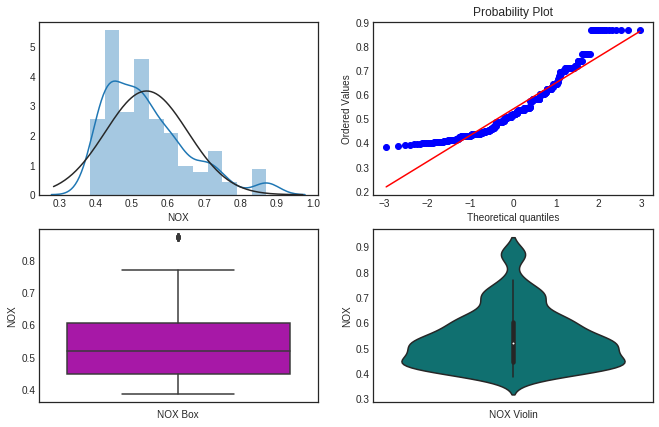

In [17]:
name = cols[4]
dist_skew_box_vio(data,name)

### 5

In [18]:
name = cols[5]

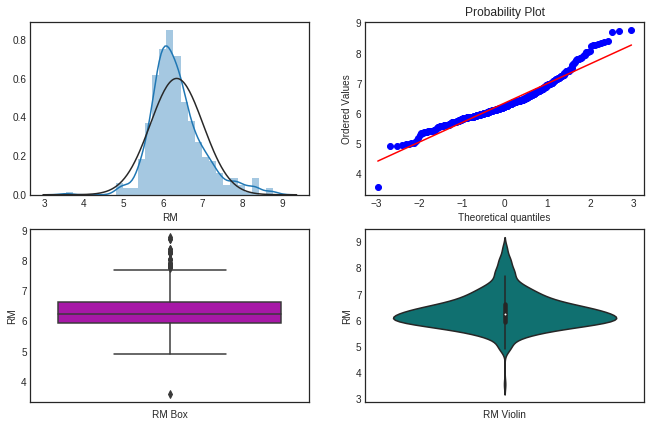

In [19]:
dist_skew_box_vio(data,name)

'RM' looks like it is almost  perfectly uniformly distributed and very less outliers present

No Suitable t_type Specified. Returning Data


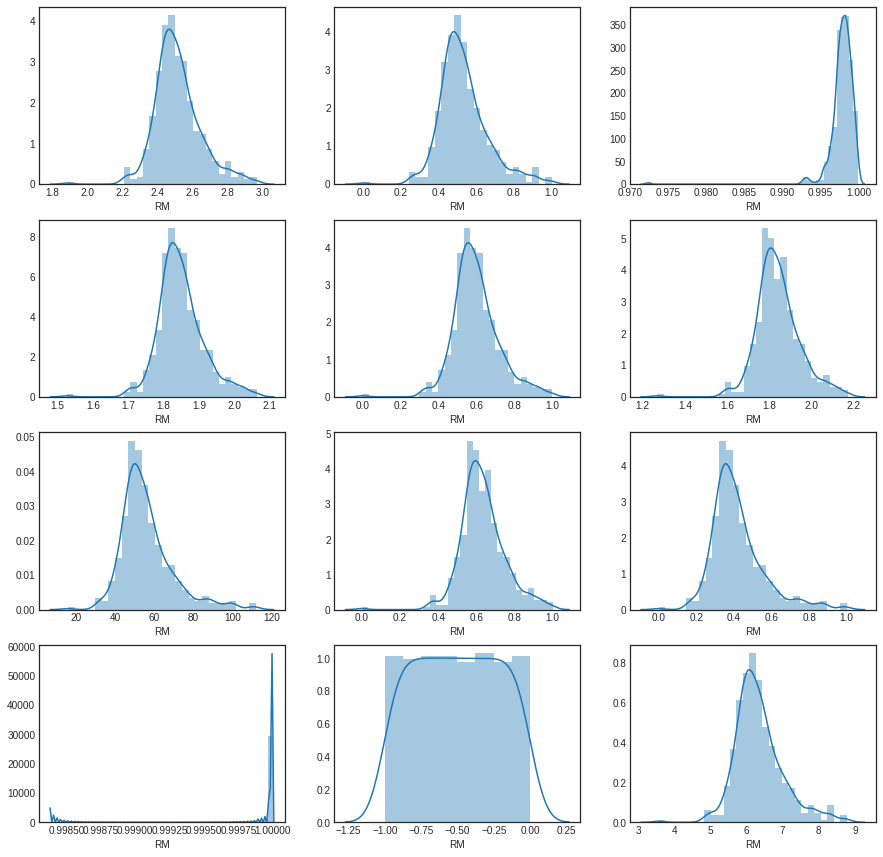

In [20]:
f,ax = plt.subplots(4,3,figsize=(15,15))
ax = ax.ravel()
for i in range(12):
    sns.distplot(transform_data(data[name],t_type=i),ax=ax[i])

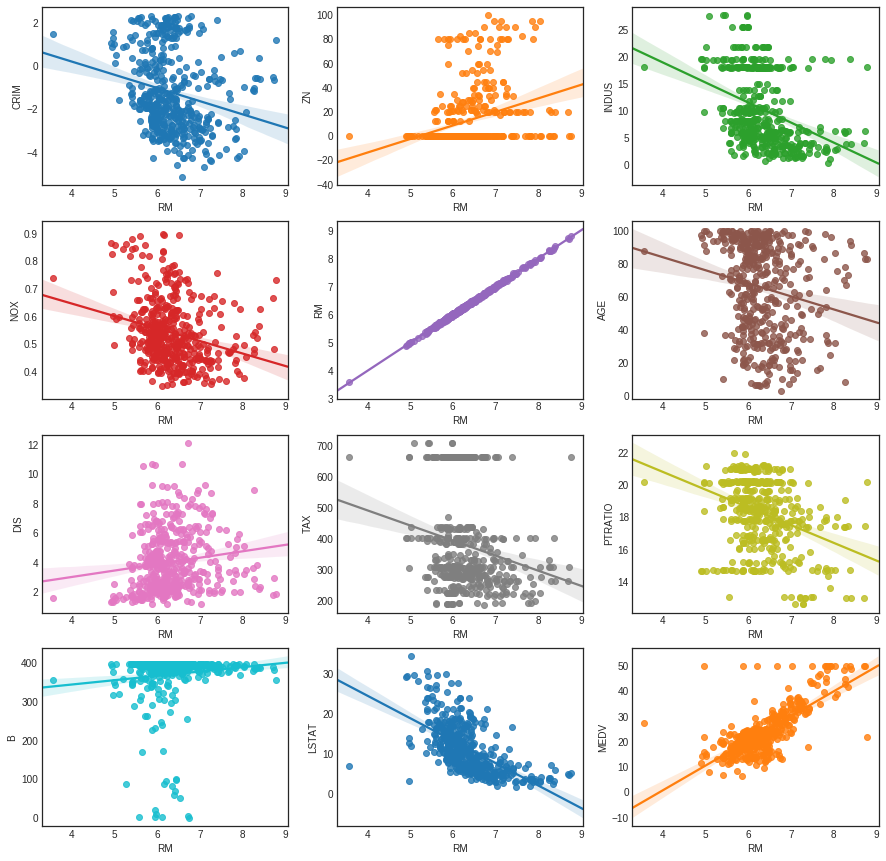

In [21]:
regression_prob_plot(data.drop(['CHAS','RAD'],axis=1),name,cols=3,PAD=7)

RM and MEDV are highly related positively. IT means that with increase in RM, the MEDV increase proportionally in positive direction

### 6

In [22]:
name = cols[6]

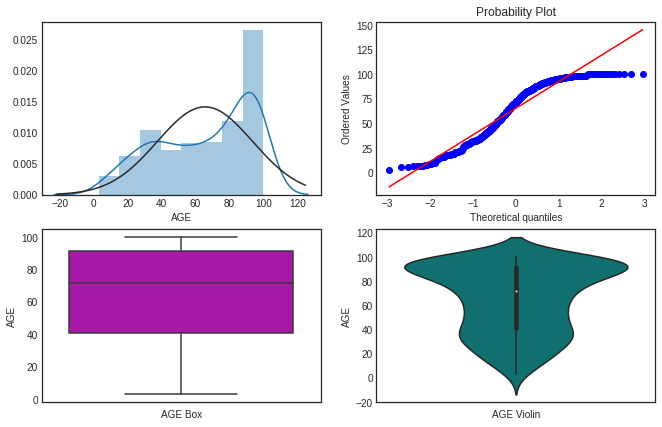

In [23]:
dist_skew_box_vio(data,name)

Age is negatively distributed with not outliers

No Suitable t_type Specified. Returning Data


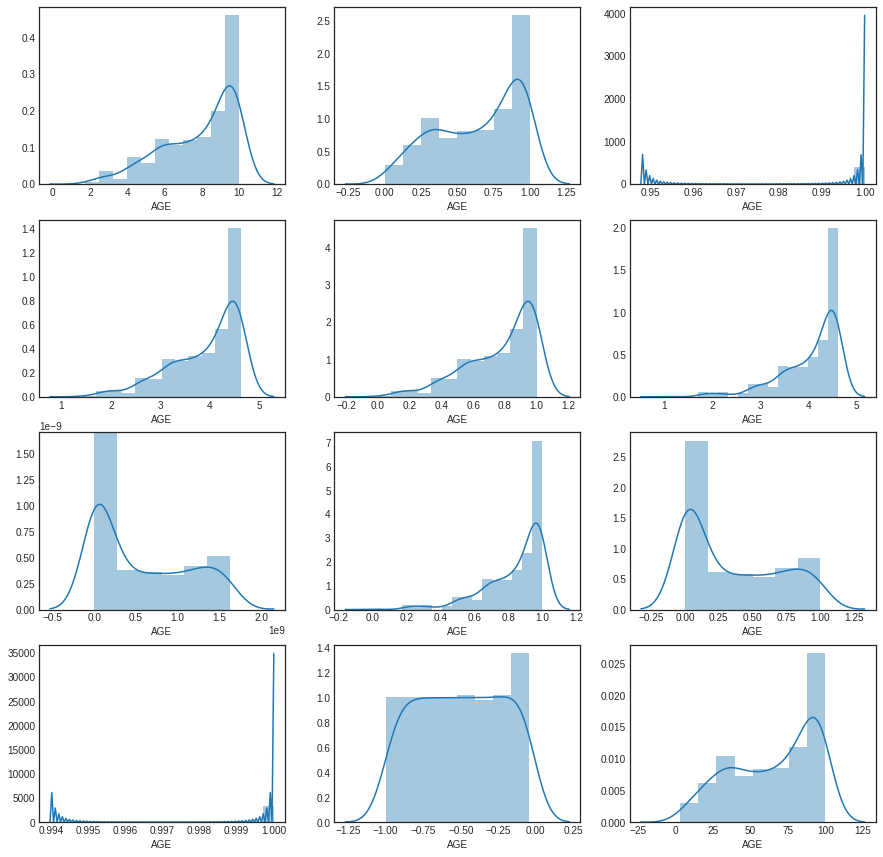

In [24]:
f,ax = plt.subplots(4,3,figsize=(15,15))
ax = ax.ravel()
for i in range(12):
    sns.distplot(transform_data(data[name],t_type=i),ax=ax[i])

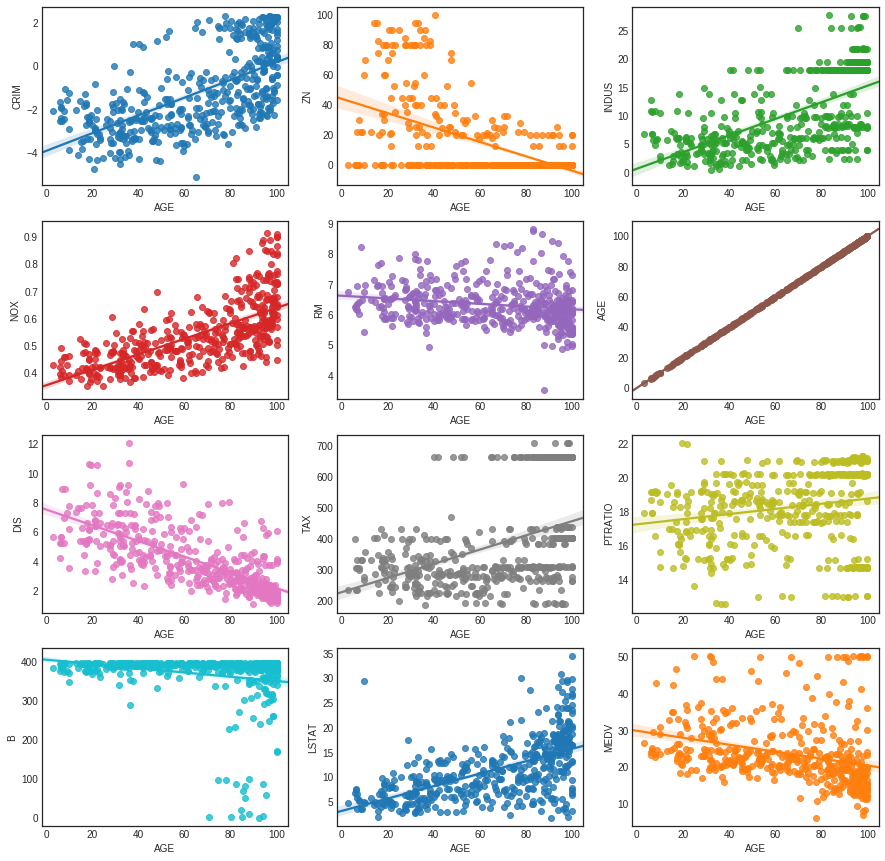

In [25]:
regression_prob_plot(data.drop(['CHAS','RAD'],axis=1),name,cols=3,PAD=7)

AGE is related to many of the columns such as MEDV, negatively, DIS, HIghly positevely, NOX, CRIM positevely

### 7

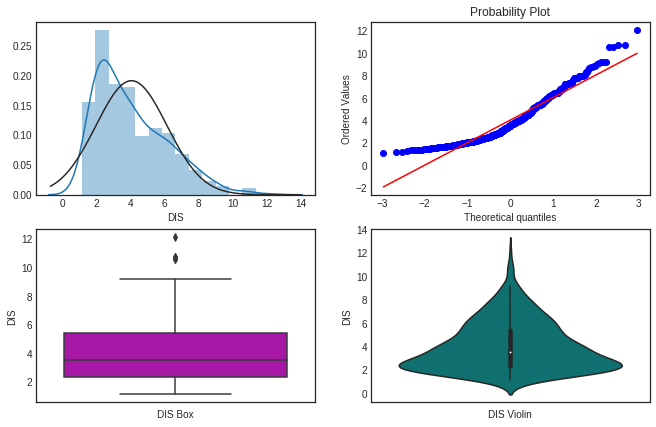

In [26]:
name = cols[7]
dist_skew_box_vio(data,name)

### 10

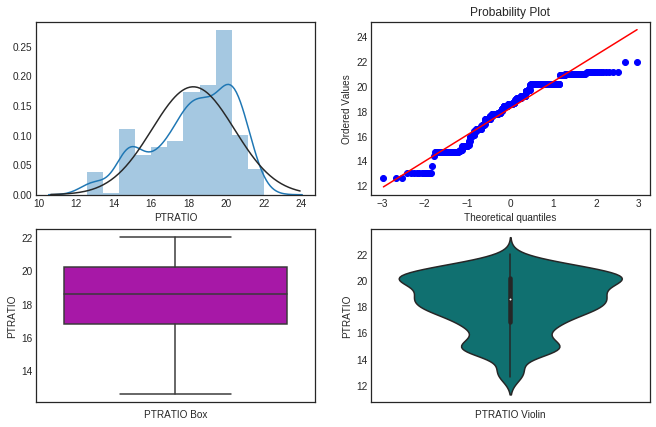

In [27]:
name = cols[10]
dist_skew_box_vio(data,name)

### 11

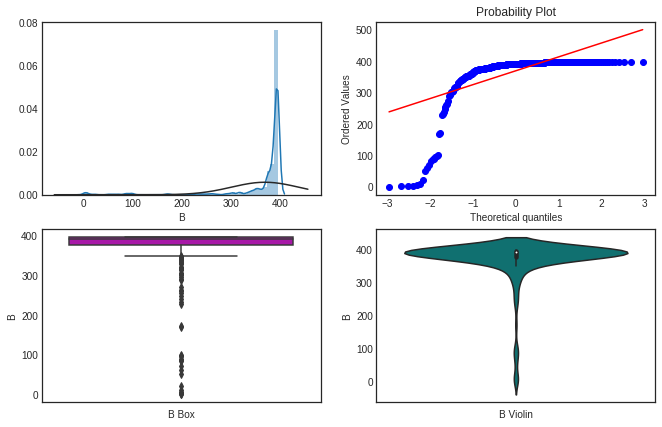

In [28]:
name = cols[11]
dist_skew_box_vio(data,name)

### 12

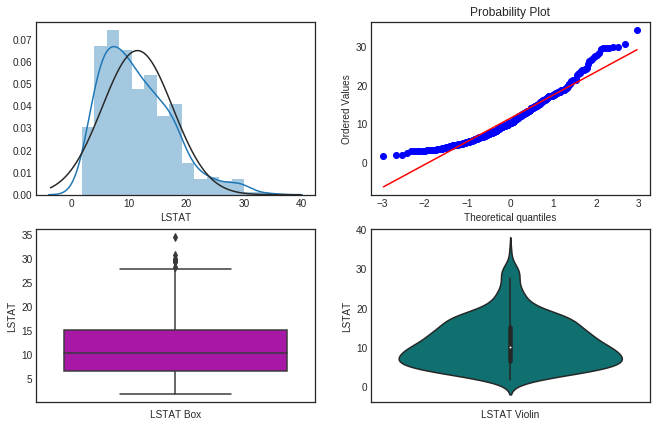

In [29]:
name = cols[12]
dist_skew_box_vio(data,name)

### 13

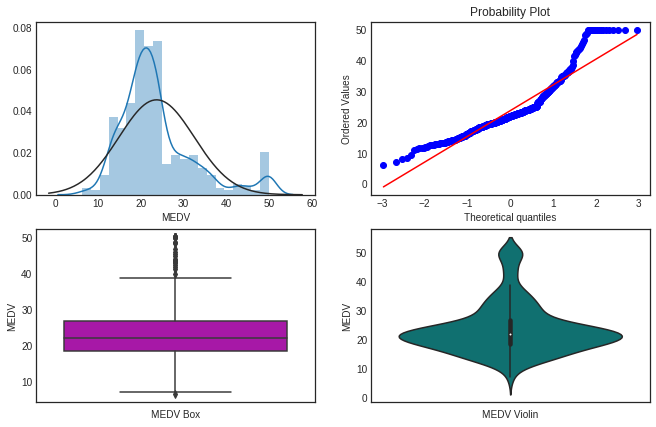

In [30]:
name = cols[13]
dist_skew_box_vio(data,name)

There are many values in target or output which are beyond the theoratical quantile. MEDV is not as skewed as other variable

In [31]:
def fix_heatmap():
        '''
        fix the half cut upper and lower boxes of a heatmap in newer versions of Seaborn
        '''
        b, t = plt.ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        plt.ylim(b, t) # update the ylim(bottom, top) values
        plt.show()


def show_corr(df,plot=True,return_corr_df=False,size=(10,10)):
    '''
    Show the correlation within a dataframe
    args:
        df: pandas datadframe
        plot: {bool} default False. Whether to show the heatmap or not
        return_corr_df: return the correlated df or not
        size: tuple (w,h) for the size of plot
    out:
        returns correlated squared DataFrame 
    '''
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
   
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(corr,mask=mask,annot=True, cmap='coolwarm',facecolor='b',lw=2, ax=ax)
    fix_heatmap()


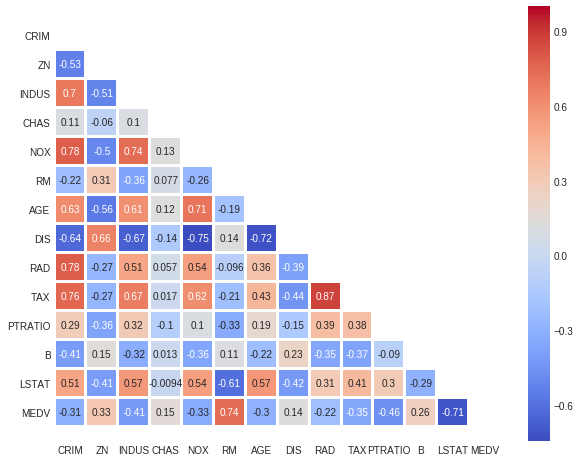

In [32]:
show_corr(data,size=(10,8))

LSTAT is highly correlated with MEDV as as we speculated AGE isrelated with many of the columns

## Splitting into features and target

In [33]:
X = data.drop('MEDV',axis=1).values
y = data['MEDV'].ravel()

## Train and test split

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=SEED,test_size=0.2)

# Model Building and Training

In [35]:
clf = LinearRegression(normalize=True,n_jobs=-1).fit(X_train,y_train)
predicted_y_train = clf.predict(X_train)
r2_train = r2_score(y_train,predicted_y_train)
print(f'R-Square value from training is: {r2_train}')

R-Square value from training is: 0.7486705502826614


# Generating two new synthetic data points

In [36]:
h1 = np.array([1.7,46,30,1,0.45,5.0,75,8.4,12,530,15.95,195,20.84])
h2 = np.array([0.4,53,25,0,0.99,6.3,35,5.3,24,535,10.53,130,23.34])
attributes = np.stack((h1,h2))

In [37]:
attributes

array([[1.700e+00, 4.600e+01, 3.000e+01, 1.000e+00, 4.500e-01, 5.000e+00,
        7.500e+01, 8.400e+00, 1.200e+01, 5.300e+02, 1.595e+01, 1.950e+02,
        2.084e+01],
       [4.000e-01, 5.300e+01, 2.500e+01, 0.000e+00, 9.900e-01, 6.300e+00,
        3.500e+01, 5.300e+00, 2.400e+01, 5.350e+02, 1.053e+01, 1.300e+02,
        2.334e+01]])

In [38]:
attributes.shape

(2, 13)

In [39]:
pred = clf.predict(attributes)
print(f'First House has Predicted MEDV of {pred[0]} and Second house has  Predicted MEDV of {pred[1]} ')

First House has Predicted MEDV of 12.261831406489133 and Second house has  Predicted MEDV of 16.564629044344453 


## Predicting House Prices on second data part

In [40]:
y_pred = clf.predict(X_test)
r2_test = r2_score(y_test,y_pred)
print(f'R-Square value from testing data is: {r2_test}')

R-Square value from testing data is: 0.7108981740900874


### 10 fold CV

In [41]:
result = cross_validate(LinearRegression(),cv=10,X=X,y=y,scoring='r2',return_train_score=True)

In [42]:
result

{'fit_time': array([0.00113583, 0.00075865, 0.00074673, 0.0007236 , 0.00074029,
        0.00073028, 0.00074196, 0.00071573, 0.00071573, 0.00071907]),
 'score_time': array([0.00048375, 0.00044203, 0.00043726, 0.00043416, 0.00044823,
        0.00043058, 0.00043559, 0.0004282 , 0.00044632, 0.00042701]),
 'test_score': array([ 0.75003916,  0.36759185,  0.8053007 ,  0.77568432,  0.64222914,
         0.77201948,  0.73275553,  0.53134665, -0.17737099,  0.18343819]),
 'train_score': array([0.73965145, 0.75099757, 0.73927152, 0.73584382, 0.72642865,
        0.71774118, 0.73593125, 0.74559101, 0.86290324, 0.7473795 ])}

In [43]:
print(f"Average r2 TRAIN score for 10 folds is {result['train_score'].mean()}")
print(f"Average r2 TEST for 10 folds is {result['test_score'].mean()}")

Average r2 TRAIN score for 10 folds is 0.7501739202451956
Average r2 TEST for 10 folds is 0.538303403872563
